In [1]:
## importing libraraies
## data maupulation
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import torch

## For customizing the plots
plt.style.use('dark_background')
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches


## methods and stopwords text processing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

## Core packages for general use
import random
import time
import datetime
import warnings
warnings.filterwarnings("ignore")

In [2]:
## creating a Stopwords set
import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
df = pd.read_csv("Reviews.csv")
print(df.shape)
df = df.head(1000)
print(df.shape)

(568454, 10)
(1000, 10)


In [5]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


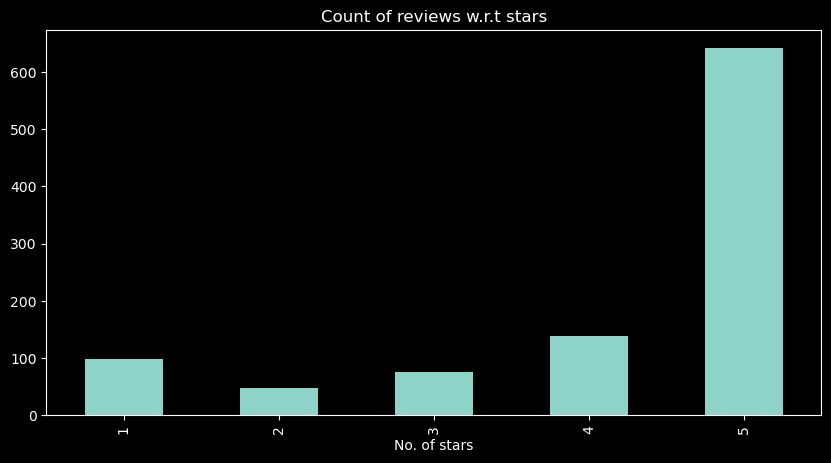

In [6]:
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of reviews w.r.t stars',
          figsize=(10, 5))
ax.set_xlabel('No. of stars')
plt.show()

In [7]:
def preprocess_review_text(review):
    """
    Runs a set of transformational steps to
    preprocess the text of the review.
    """
    
    # remove any urls
    review = re.sub(r"http\S+|www\S+|https\S+", "", review, flags=re.MULTILINE)
    
    # remove punctuations
    review = review.translate(str.maketrans("", "", string.punctuation))
    
    # remove user @ references and '#' from review
    review = re.sub(r'\@\w+|\#', "", review)
    
    # remove stopwords
    review_tokens = word_tokenize(review)
    filtered_words = [word for word in review_tokens if word not in stop_words]
    
    # stemming
    ps = PorterStemmer()
    stemmed_words = [ps.stem(w) for w in filtered_words]
    
    #lemmatizing
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in stemmed_words]
    
    return " ".join(lemma_words)


preprocess_review_text("It was a great value and I like the package size but not vinegary enough for me. Won't order this brand again. Great chips otherwise.")

'it great valu i like packag size vinegari enough wont order brand great chip otherwis'

In [8]:
example = df['Text'][501]
print(example)

It was a great value and I like the package size but not vinegary enough for me. Won't order this brand again. Great chips otherwise.


In [9]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['It', 'was', 'a', 'great', 'value', 'and', 'I', 'like', 'the', 'package']

In [10]:
# part of speech
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('It', 'PRP'),
 ('was', 'VBD'),
 ('a', 'DT'),
 ('great', 'JJ'),
 ('value', 'NN'),
 ('and', 'CC'),
 ('I', 'PRP'),
 ('like', 'VBP'),
 ('the', 'DT'),
 ('package', 'NN')]

In [11]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [12]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [13]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [14]:
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 0.62, 'pos': 0.38, 'compound': 0.8922}

In [15]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [16]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df,how='left')

In [17]:
# Now we have sentiment score and metadata
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


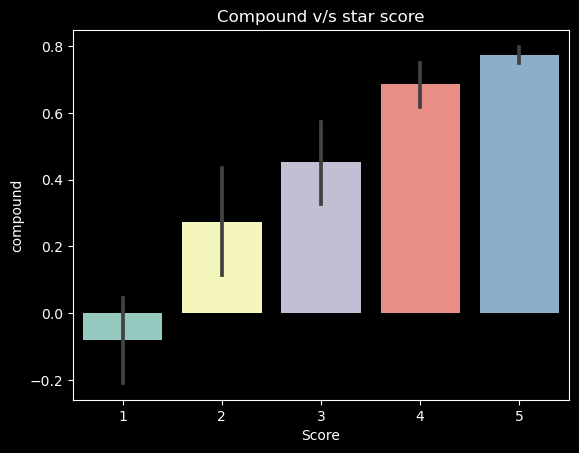

In [18]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compound v/s star score')
plt.show()

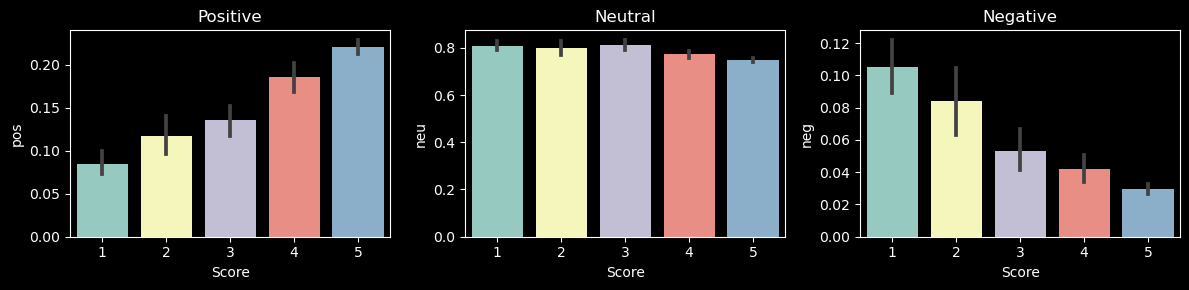

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [20]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [21]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [22]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://download.pytorch.org/whl/cu117


In [23]:
# VADER results on example
print(example)
sia.polarity_scores(example)

It was a great value and I like the package size but not vinegary enough for me. Won't order this brand again. Great chips otherwise.


{'neg': 0.0, 'neu': 0.62, 'pos': 0.38, 'compound': 0.8922}

In [24]:
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
output

SequenceClassifierOutput(loss=None, logits=tensor([[-1.0088,  0.0319,  1.2222]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [25]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()     #detaching tensor output and converting into numpy array
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.07610434, 'roberta_neu': 0.2154621, 'roberta_pos': 0.7084335}


In [26]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()    
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict
print(scores_dict)

{'roberta_neg': 0.07610434, 'roberta_neu': 0.2154621, 'roberta_pos': 0.7084335}


In [27]:
# Comparing the results of vader and roberta
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187
Broke for id 529
Broke for id 540
Broke for id 746
Broke for id 863


In [28]:
pd.DataFrame(res).T

,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos
1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395
2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600
3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704
4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486
5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063
...,...,...,...,...,...,...,...
996,0.026,0.721,0.253,0.9788,0.001335,0.006112,0.992553
997,0.000,0.786,0.214,0.9309,0.002649,0.016077,0.981274
998,0.000,0.673,0.327,0.9634,0.001362,0.011372,0.987266
999,0.063,0.874,0.062,-0.0129,0.661606,0.293687,0.044707


In [29]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df,how='left')

In [30]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

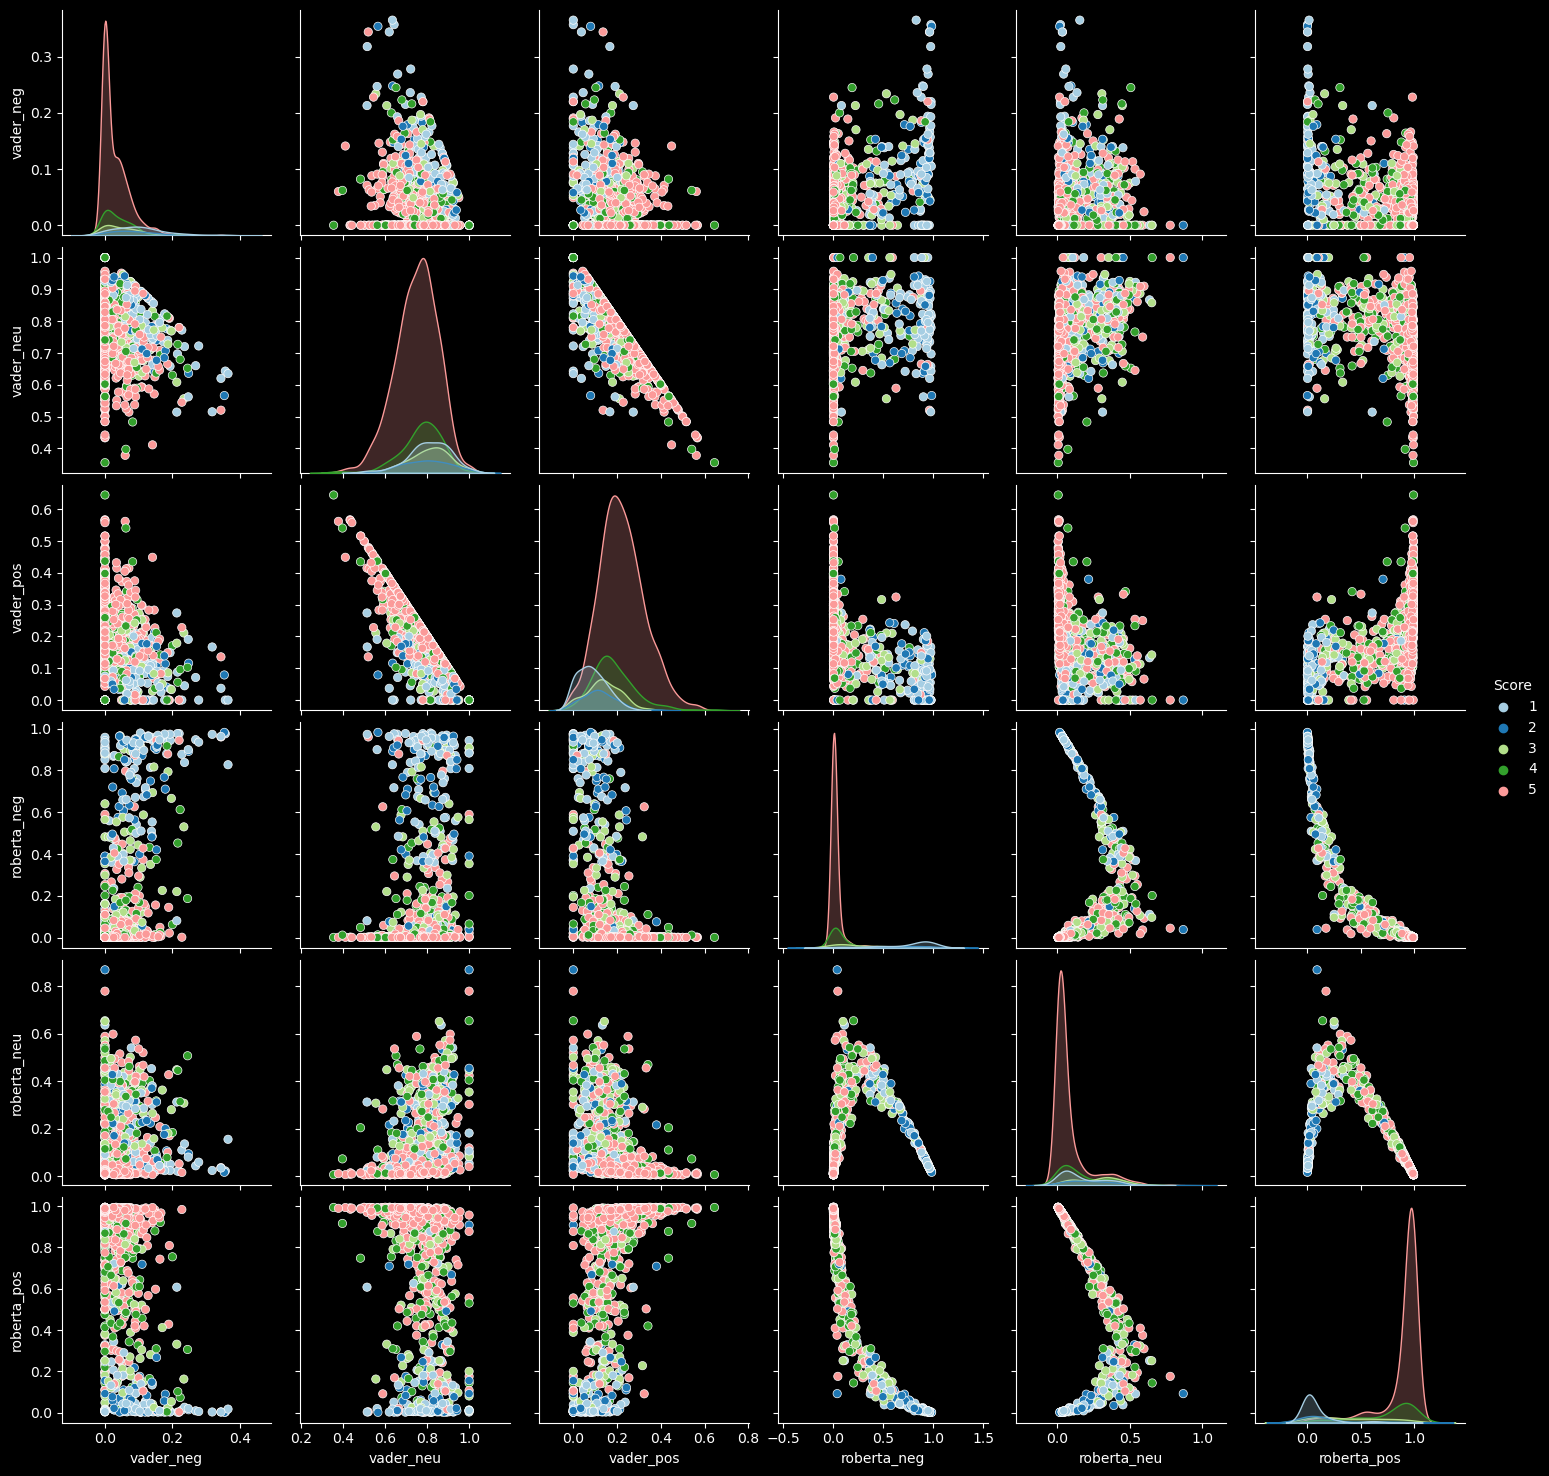

In [31]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='Paired')
plt.show()

In [32]:
# positive sentiment 1-Star view
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

"I just wanted to post here that I found small bits of plastic in this food as I was feeding my 9 month old.  Plastic!!! in food!!!! baby food!!!  So please be careful if you buy this or are considering it.<br /><br />My daughter LOVES this food-- it's actually her favorite.  This is the first time we have noticed plastic in it in over 2 months."

In [33]:
# positive sentiment 1-Star view
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [34]:
# negative sentiment 5-Star view
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [35]:
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [36]:
# THE MAGIC
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [37]:
sent_pipeline('I do not love sentiment analysis!')

[{'label': 'NEGATIVE', 'score': 0.997802197933197}]

In [38]:
sent_pipeline('I love sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [39]:
sent_pipeline('I love using this to sweeten tea, coffee, etc. It tastes much better than other low glycemic sweeteners - there is no bitter aftertaste.')

[{'label': 'POSITIVE', 'score': 0.9963067770004272}]

In [40]:
# THE END.... THANK YOU